**Задание 1**

Проанализировать набор данных и ответить на следующие вопросы:

1) Какой % наблюдений выходит за 5 и 95 перцентиль?

2) Какому закону распределения отвечают данные? На основе чего вы так решили?

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

Описание данных:

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
from statsmodels.api import qqplot
from scipy.stats import mannwhitneyu
from scipy.stats import scoreatpercentile
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import chisquare
from scipy.stats import boxcox
from scipy.stats import ks_2samp
from scipy.stats import epps_singleton_2samp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pd.read_csv('test_1_1.csv')

In [3]:
data.columns

Index([';"metrics"'], dtype='object')

In [0]:
data = data.rename(columns={';"metrics"': "metrics"})

In [0]:
data['metrics'] = data['metrics'].apply(lambda x: x.split(';')[1])

In [6]:
data.head()

,metrics
0,1
1,1
2,4
3,1
4,1


In [0]:
mass = data.metrics.to_numpy(dtype=np.int32)

In [0]:
q5, q95 = np.percentile(mass, [5, 95])

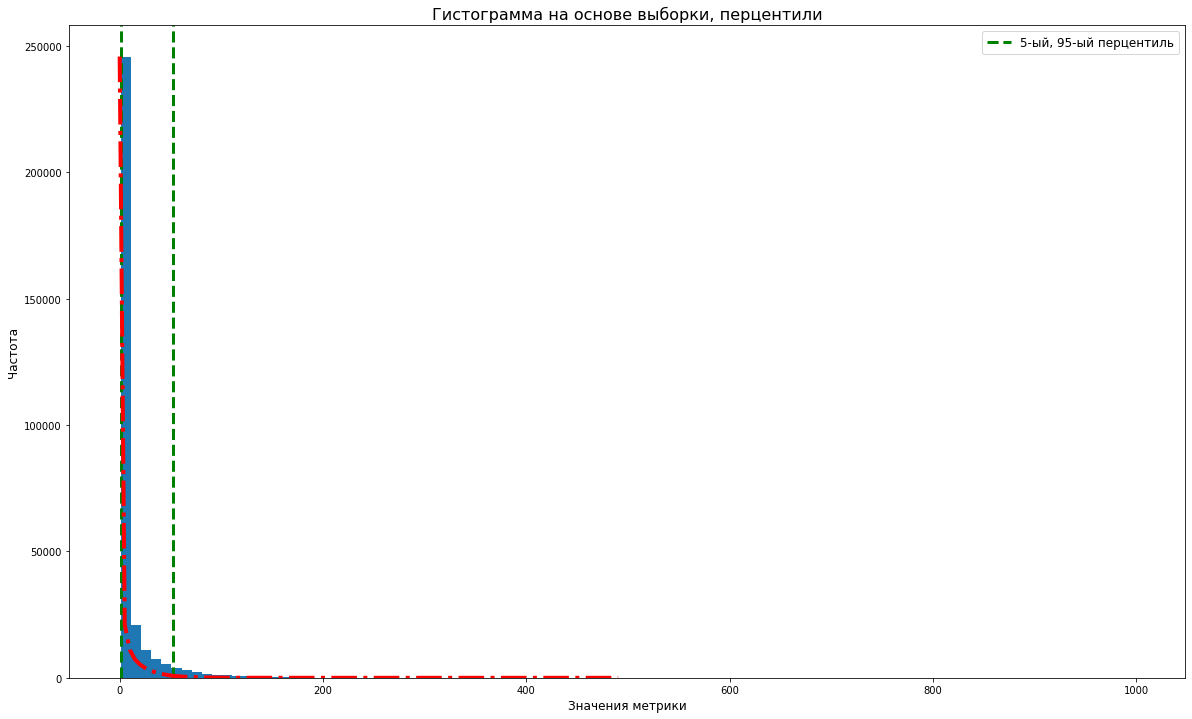

In [86]:
plt.figure(figsize=(20,12))
n1=plt.hist(mass, bins=100);
line1 = plt.axvline(x=q5, linewidth=3, color='g',linestyle='--');
plt.axvline(x=q95, linewidth=3, color='g',linestyle='--');
plt.plot(n[1][:100], n1[0], linewidth=4, color='r', linestyle='-.');
plt.title("Гистограмма на основе выборки, перцентили", fontsize = 16)
plt.xlabel("Значения метрики", fontsize = 12)
plt.ylabel("Частота", fontsize = 12)
plt.legend([line1], ["5-ый, 95-ый перцентиль"], fontsize = 12);

5-ый перцентиль равен 1 и большое количество значений(>>5%) выборки равно 1, поэтому мы не получим заветных 95% после него. 

In [87]:
print("Выходит за 5-ый перцентиль: ", len(mass[mass > q5])/len(mass))

Выходит за 5-ый перцентиль:  0.569673346608482


In [88]:
print("Выходит за 95-ый перцентиль: ", len(mass[mass > q95])/len(mass))

Выходит за 95-ый перцентиль:  0.04987306046493438


In [10]:
m1 = mass.mean()
print('Первый момент : ', m1)

Первый момент :  10.146275408276


In [11]:
m2 = np.square(mass).mean()
print('Второй момент: ', m2)

Второй момент:  614.9434687246406


Распределено не нормально

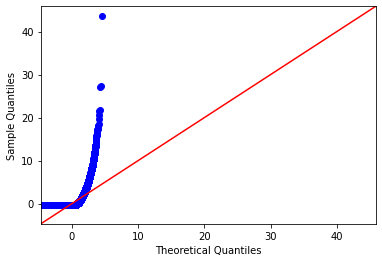

In [12]:
fig = qqplot(mass, norm, line='45', fit=True)

По методу моментов определим альфу и бета гамма-распределения

In [0]:
np.random.seed(13)
alpha = m1**2/(m2-m1**2)
beta = m1/(m2-m1**2)
X = gamma.rvs(scale=1/beta, a=alpha, size=len(mass))

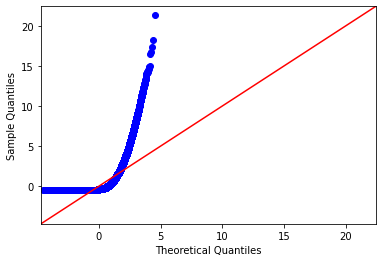

In [14]:
fig = qqplot(X, norm, line='45', fit=True)

In [15]:
alpha

0.20106952250505133

In [16]:
beta

0.01981707714547598

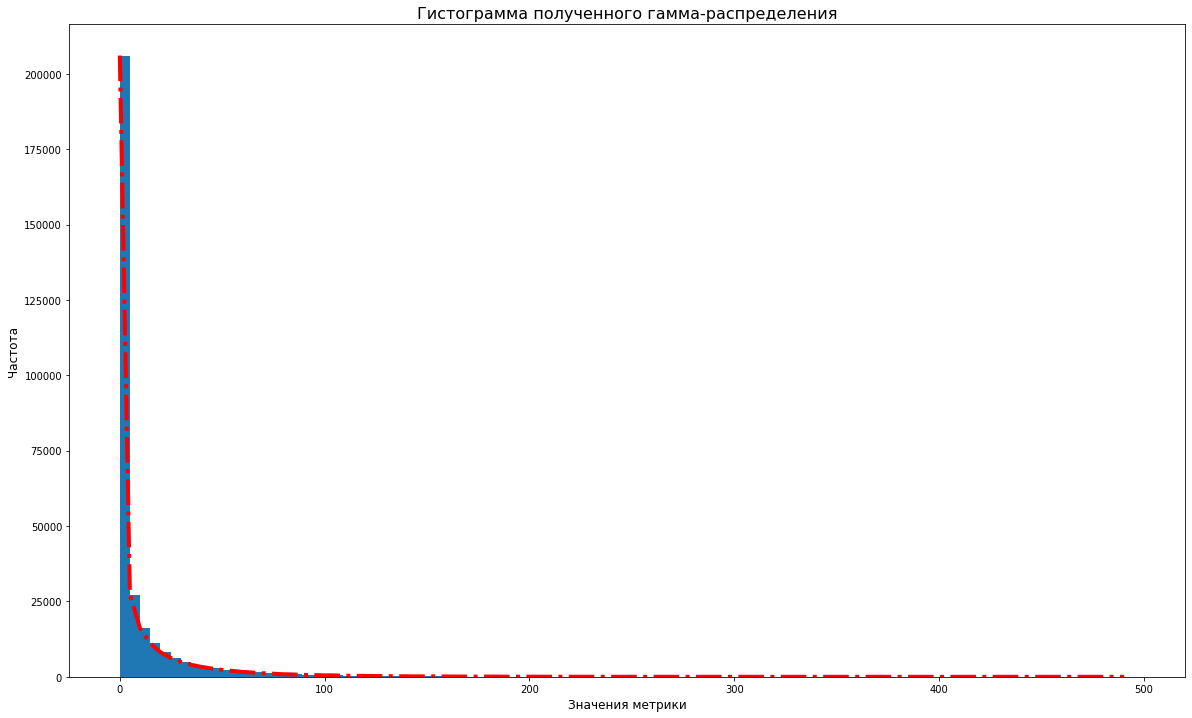

In [17]:
plt.figure(figsize=(20,12))
n=plt.hist(X, bins=100);
plt.plot(n[1][:100], n[0], linewidth=4, color='r', linestyle='-.');
plt.title("Гистограмма полученного гамма-распределения", fontsize = 16);
plt.xlabel("Значения метрики", fontsize = 12);
plt.ylabel("Частота", fontsize = 12);

Применим критерий Хи-квадрат к исходным данным и полученному с помощью метода моментов гамма-распределению (известные альфа и бета)

In [18]:
chisquare(np.bincount(mass)[np.array(data.metrics.unique(), dtype=np.int16)]/np.sum(np.bincount(mass)), gamma.pdf(np.array(data.metrics.unique(), dtype=np.int16), scale=1/beta, a=alpha))

Power_divergenceResult(statistic=11.600994652997633, pvalue=1.0)

1) 56.9 и 5

2) Данные отвечают гамма-распределению. Вывод сделан на основе метода моментов и критерия Хи-квадрат.

**Задание 2**

Определить, можно сравнить две представленные выборки t критерием Стьюдента? 

Если нельзя сравнивать t-критерием, то что будем использовать и почему?

Ответ аргументировать и описать 

[Ссылка на данные](https://drive.google.com/file/d/1blvC6TEBWghhVMexjOdoGEjzhZZh3wSy/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

*Вместе с ответом на задание приложить код*

In [0]:
ab = pd.read_csv('test_1_2.csv')

In [20]:
ab.columns

Index([';"variant";"metrics"'], dtype='object')

In [0]:
ab = ab.rename(columns={';"variant";"metrics"': "variant+metrics"})

In [0]:
ab['variant'] = ab["variant+metrics"].apply(lambda x: x.split(';')[1])
ab['metrics'] = ab["variant+metrics"].apply(lambda x: x.split(';')[2])
ab.drop("variant+metrics", axis=1, inplace=True)

In [23]:
ab.head()

,variant,metrics
0,"""A""",1
1,"""B""",1
2,"""A""",4
3,"""B""",37
4,"""B""",4


In [0]:
A_data = ab[ab.variant == '"A"'].metrics.to_numpy(dtype=np.int32)

In [25]:
A_data

array([ 1,  4, 15, ..., 12,  8,  1], dtype=int32)

In [0]:
B_data = ab[ab.variant == '"B"'].metrics.to_numpy(dtype=np.int32)

In [27]:
B_data

array([ 1, 37,  4, ...,  2, 11, 81], dtype=int32)

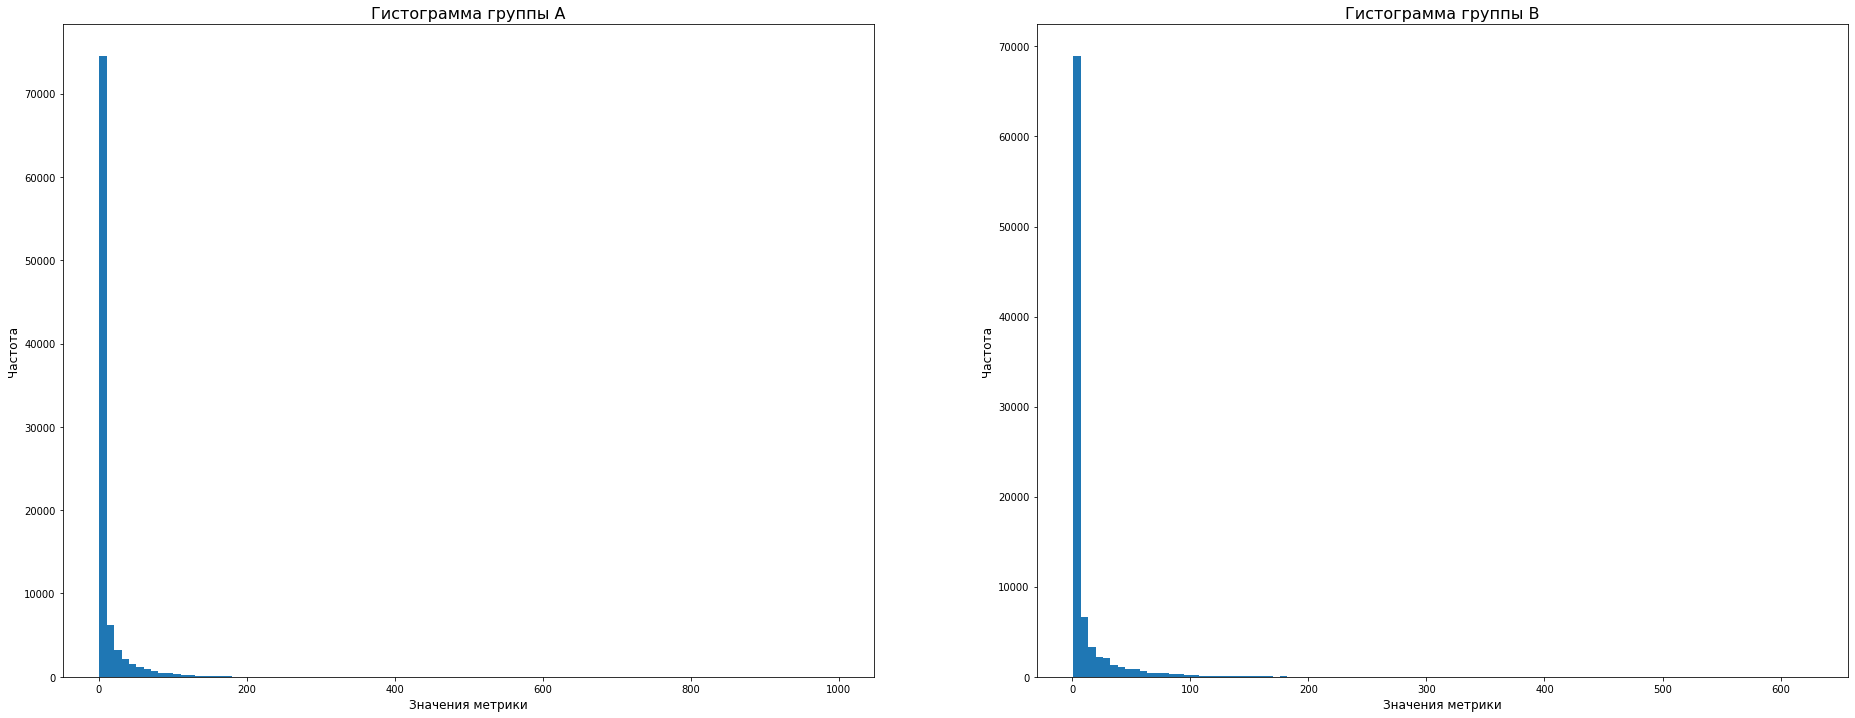

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(32,12))
ax1.hist(A_data, bins=100);
ax1.set_title("Гистограмма группы А", fontsize = 16);
ax1.set_xlabel("Значения метрики", fontsize = 12);
ax1.set_ylabel("Частота", fontsize = 12);
ax2.hist(B_data, bins=100);
ax2.set_title("Гистограмма группы B", fontsize = 16);
ax2.set_xlabel("Значения метрики", fontsize = 12);
ax2.set_ylabel("Частота", fontsize = 12);

Q-QPlot для нормального распределения

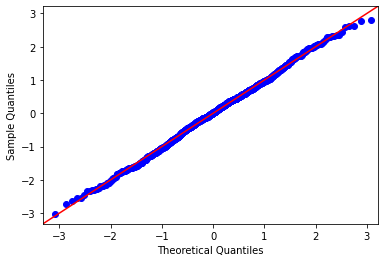

In [29]:
norm_dist = norm.rvs(size=1000)
fig = qqplot(norm_dist, norm, line='45', fit=True)

Q-QPlot для наших выборок

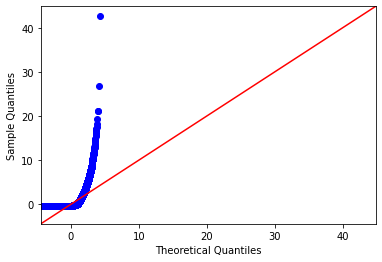

In [30]:
fig = qqplot(A_data, norm, line='45', fit=True)

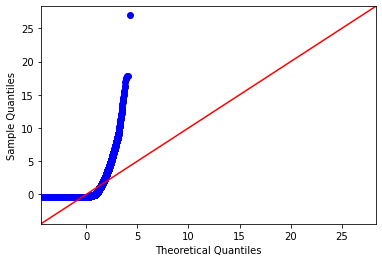

In [31]:
fig = qqplot(B_data, norm, line='45', fit=True)

In [32]:
shapiro(A_data)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.4299488663673401, 0.0)

In [33]:
shapiro(B_data)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.45065927505493164, 0.0)

In [34]:
levene(A_data, B_data)

LeveneResult(statistic=4.313416821004634, pvalue=0.03781432358426188)

Выборки нельзя сравнить критерием Cтьюдента, т.к. не выполняется ни условие нормальности распределения, ни условие гомогенности дисперсий. Можем воспользоваться непараметрическим критерием Манна-Уитни, предложенным в лекции. 

In [35]:
mannwhitneyu(A_data, B_data)

MannwhitneyuResult(statistic=4195358346.0, pvalue=1.365559131227319e-05)

Критерий Манна-Уитни представляет непараметрическую альтернативу t-критерия для независимых выборок. Преимущество его состоит в том, что мы отказываемся от предположения нормальности распределения и одинаковых дисперсий.

P-value ~ 0, распределения разные

**Задание 3**

Дано две выборки по А/Б тесту.

Две выборки несбалансированные - кол-во пользователей в каждой группе разные.

Метрика, которую меряем в эксперименте (и которую используем для определения группы, которая лучше себя показала) - кол-во просмотренных страниц на пользователя 

Как вы будете принимать решение, какая группа лучше А или Б, и какие статистические методы (критерии) вы будете использовать, какие преобразования к данным применять? P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

[Ссылка на данные](https://drive.google.com/file/d/1_g7Dw7-8QzTS47D6GNKMb0FzqMAWBDba/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

In [0]:
ab2 = pd.read_csv('hw2_test_1_3.csv')

In [37]:
ab2.columns

Index([';"variant";"metrics"'], dtype='object')

In [0]:
ab2 = ab2.rename(columns={';"variant";"metrics"': "variant+metrics"})

In [39]:
ab2['variant'] = ab2["variant+metrics"].apply(lambda x: x.split(';')[1])
ab2['metrics'] = ab2["variant+metrics"].apply(lambda x: x.split(';')[2])
ab2.drop("variant+metrics", axis=1, inplace=True)
ab2.head()

,variant,metrics
0,"""A""",1
1,"""A""",4
2,"""A""",15
3,"""A""",1
4,"""A""",10


In [40]:
A_data2 = ab2[ab2.variant == '"A"'].metrics.to_numpy(dtype=np.int32)
print(len(A_data2))

92686


In [41]:
B_data2 = ab2[ab2.variant == '"D"'].metrics.to_numpy(dtype=np.int32)
print(len(B_data2))

15413


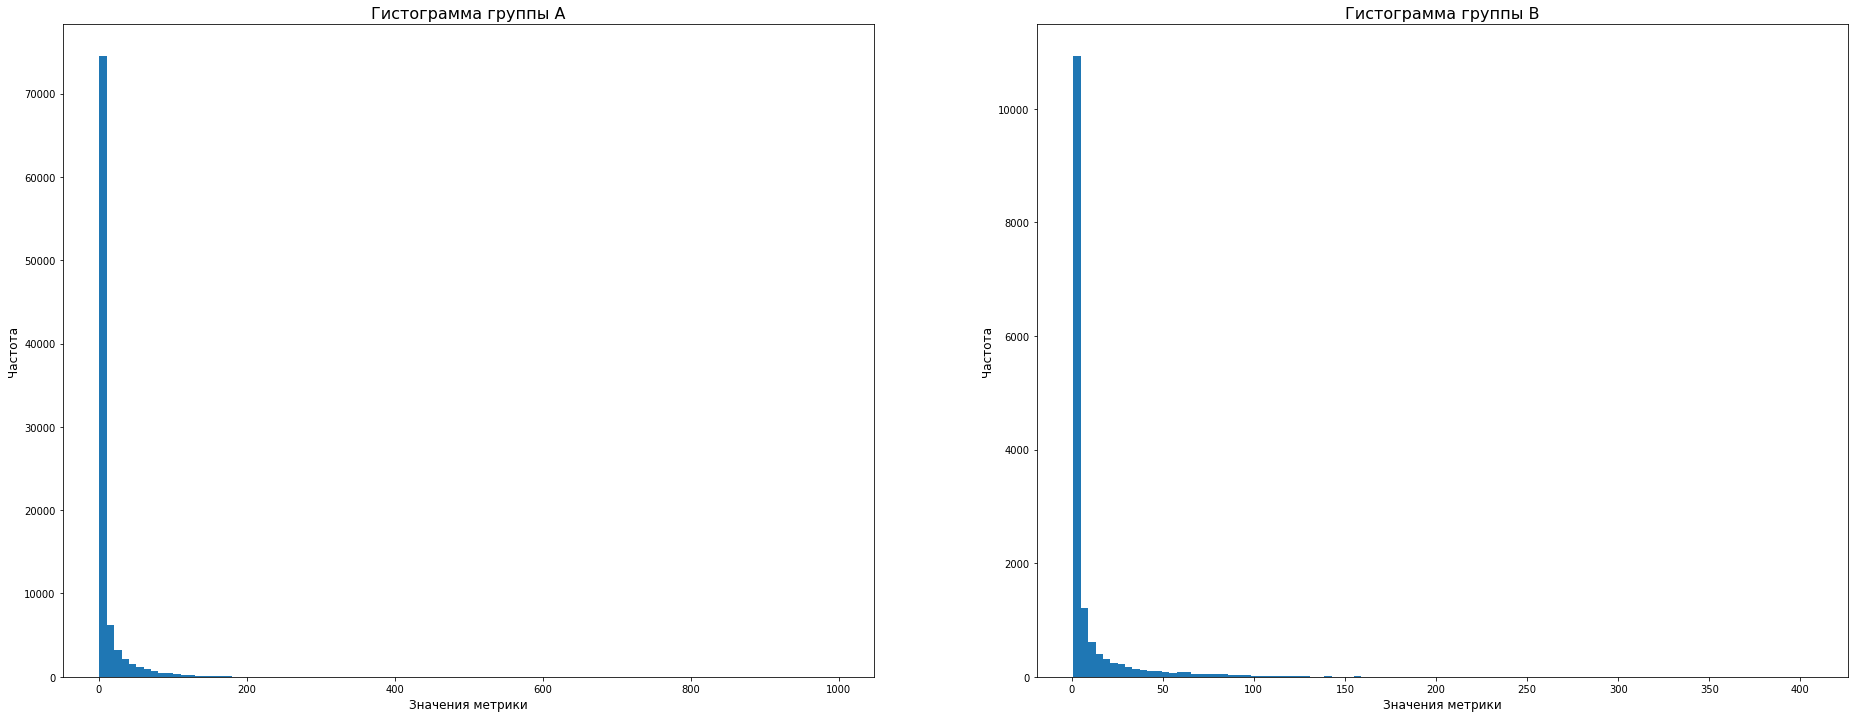

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(32,12))
ax1.hist(A_data2, bins=100);
ax1.set_title("Гистограмма группы А", fontsize = 16);
ax1.set_xlabel("Значения метрики", fontsize = 12);
ax1.set_ylabel("Частота", fontsize = 12);
ax2.hist(B_data2, bins=100);
ax2.set_title("Гистограмма группы B", fontsize = 16);
ax2.set_xlabel("Значения метрики", fontsize = 12);
ax2.set_ylabel("Частота", fontsize = 12);

In [43]:
A_mean = np.mean(A_data2)
B_mean = np.mean(B_data2)
A_std = np.std(A_data2)
B_std = np.std(B_data2)
diff = abs(A_mean - B_mean)
print('A_mean : %s' % A_mean)
print('B_mean : %s' % B_mean)
print('A_mean - B_mean: %s' % diff)
print('A_std : %s' % A_std)
print('B_std : %s' % B_std)
print('A size : %s' % len(A_data2))
print('B size : %s' % len(B_data2))

A_mean : 10.099561961892842
B_mean : 9.942386297281516
A_mean - B_mean: 0.15717566461132648
A_std : 23.13002345542719
B_std : 21.80203964440777
A size : 92686
B size : 15413


**Bootstrap**

https://www.youtube.com/watch?v=9STZ7MxkNVg

Ho - распределения у групп одинаковые

In [44]:
!pip install bootstrapped

  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13954 sha256=c9e219a80f9f843fad2be4e6d75d728fc14a57f959b9fbd38d1de4947f804ca1
  Stored in directory: /root/.cache/pip/wheels/38/23/ee/3493dbb0019f511085117a962bfadb1f7d221e7b78761943a7
Successfully built bootstrapped


In [0]:
import bootstrapped.bootstrap as bt
import bootstrapped.stats_functions as sf

In [0]:
def bootstrap(iters):
  l = list()
  for i in range(iters):
    A = bt.bootstrap(ab2.metrics.to_numpy(dtype=np.int32), sf.mean, num_iterations=1, iteration_batch_size=len(A_data2), num_threads=4, return_distribution=True)
    B = bt.bootstrap(ab2.metrics.to_numpy(dtype=np.int32), sf.mean, num_iterations=1, iteration_batch_size=len(B_data2), num_threads=4, return_distribution=True)
    l.append(abs(A-B))
  return l

In [0]:
num_iter = 1000
means_diff = np.array(bootstrap(num_iter))

In [0]:
Pval = len(means_diff[means_diff >= diff])/num_iter

In [49]:
print("P-Value : %s" %Pval)

P-Value : 0.444


Нулевая гипотеза не отвергается, распределения одинаковые

**Задание 4**

Есть данные с большой дисперсии у метрики (диспресию метрики можно посчитать для каждой группы). Для их дальнейшего анализа дисперсию необходимо сократить. Как определить, что дисперсия действительно большая? Если она большая, как вы будете ее чистить? Ответ аргументировать и описать.  P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

Описание данных: 

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

*Вместе с ответом на задание приложить код*

In [0]:
miss4 = pd.read_csv('test_1_1.csv')

In [51]:
miss4.columns

Index([';"metrics"'], dtype='object')

In [0]:
miss4 = miss4.rename(columns={';"metrics"': "metrics"})

In [0]:
miss4['metrics'] = miss4['metrics'].apply(lambda x: x.split(';')[1])

In [54]:
miss4.head()

,metrics
0,1
1,1
2,4
3,1
4,1


In [0]:
arr = miss4.metrics.to_numpy(dtype=np.int16)

In [56]:
print("Дисперсия : ", arr.var())
print("Минимальное значение метрики : ", arr.min())
print("Максимальное значение метрики : ", arr.max())
print("Среднее метрики : ", arr.mean())

Дисперсия :  511.99656406405427
Минимальное значение метрики :  1
Максимальное значение метрики :  998
Среднее метрики :  10.146275408276


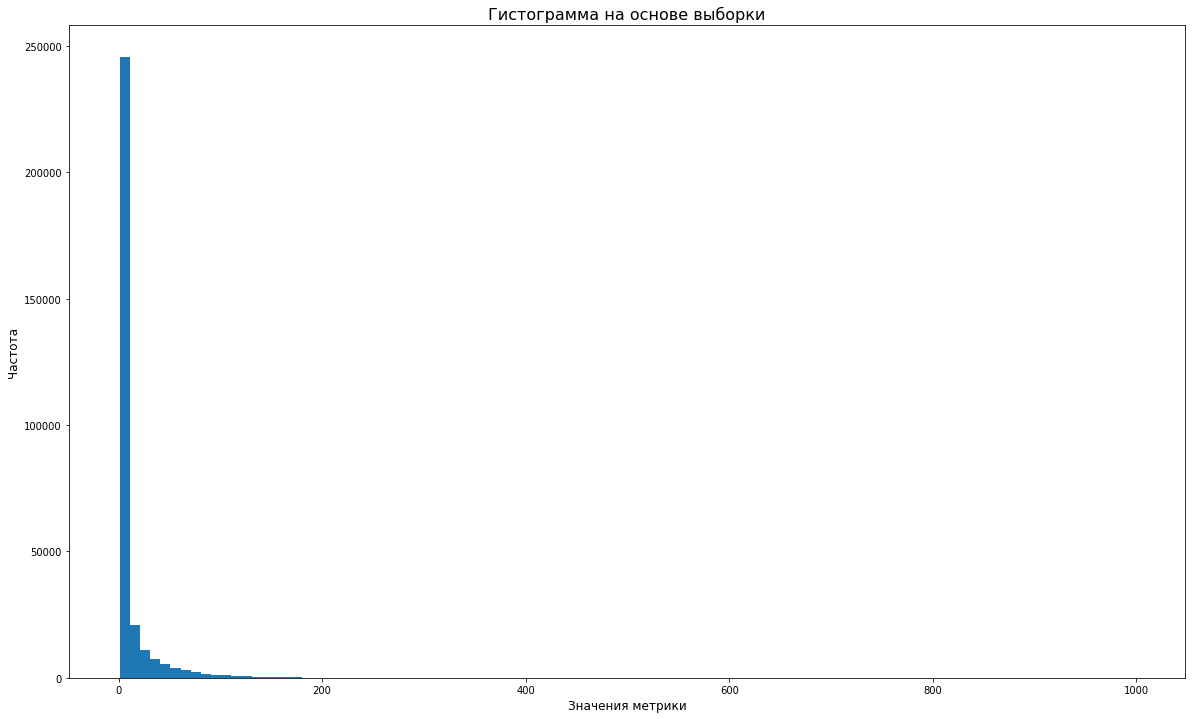

In [57]:
plt.figure(figsize=(20,12))
plt.hist(arr, bins=100);
plt.title("Гистограмма на основе выборки", fontsize = 16);
plt.xlabel("Значения метрики", fontsize = 12);
plt.ylabel("Частота", fontsize = 12);

In [0]:
scores = scoreatpercentile(arr, [[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])

In [59]:
scpd = pd.DataFrame(scores, columns=["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"], index=[""])
scpd.head()

,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
,1.0,1.0,1.0,1.0,2.0,3.0,5.0,10.0,29.0,998.0


Чтобы понять, что дисперсия действительно большая достаточно взглянуть на децили и хвост гистограммы (значения доходят почти до 1000, а большинство данных лежит до 200)

**1) Децильный метод** (разбить выборку по децилям, в получившихся группах дисперсия будет меньше, чем в исходной выборке)

- https://medium.com/statistics-experiments/%D0%B4%D0%B5%D1%86%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9-%D0%BC%D0%B5%D1%82%D0%BE%D0%B4-%D0%B8%D0%BB%D0%B8-%D1%81%D0%BE%D0%BA%D1%80%D0%B0%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D0%B8-c06758059727

- В первых четырех децилях дисперсия будет равна 0.

In [0]:
q05, q10, q25, q50, q75, q90, q95 = np.percentile(arr, [5, 10, 25, 50, 75, 90, 95])

In [0]:
a1 = arr[np.logical_and((arr >= q05), (arr < q10))]
a2 = arr[np.logical_and((arr >= q10), (arr < q25))]
a3 = arr[np.logical_and((arr >= q25), (arr < q50))]
a4 = arr[np.logical_and((arr >= q50), (arr < q75))]
a5 = arr[np.logical_and((arr >= q75), (arr < q90))]
a6= arr[np.logical_and((arr >= q90), (arr < q95))]

In [62]:
a1

array([], dtype=int16)

In [63]:
a2

array([], dtype=int16)

In [64]:
print("Дисперсия 1-ой группы : ", 0.0)
print("Дисперсия 2-ой группы : ", 0.0)
print("Дисперсия 3-ей группы : ", a3.var())
print("Дисперсия 4-ой группы : ", a4.var())
print("Дисперсия 5-ой группы : ", a5.var())
print("Дисперсия 6-ой группы : ", a6.var())

Дисперсия 1-ой группы :  0.0
Дисперсия 2-ой группы :  0.0
Дисперсия 3-ей группы :  0.0
Дисперсия 4-ой группы :  1.7392635802588017
Дисперсия 5-ой группы :  37.5334263533404
Дисперсия 6-ой группы :  43.37818755692629


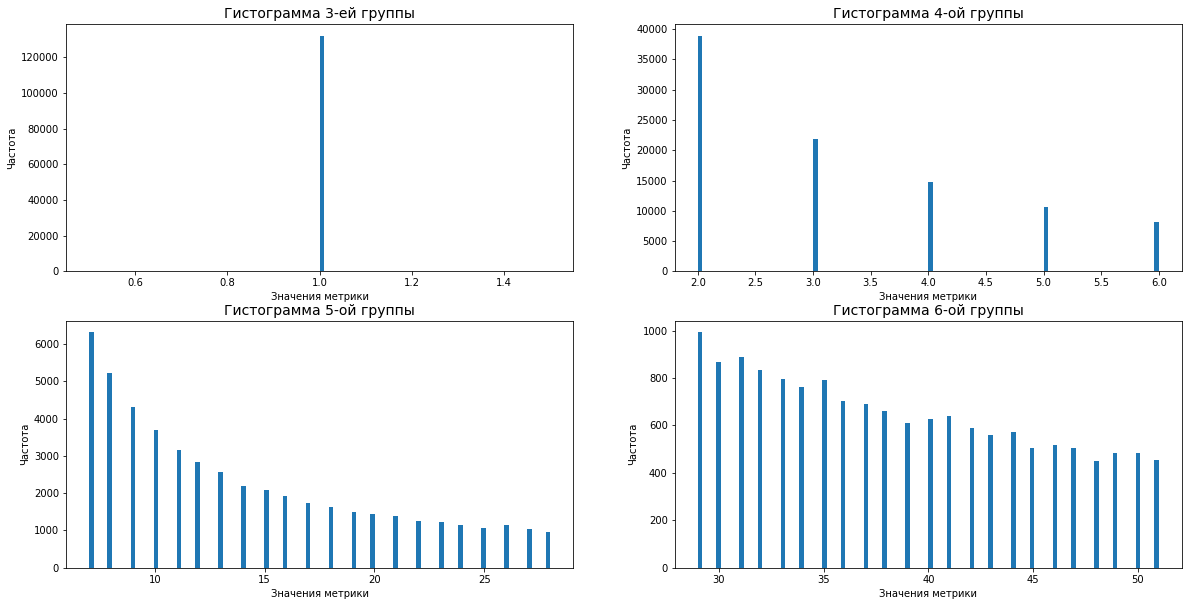

In [65]:
fig, ((ax1, ax2), (ax4, ax5)) = plt.subplots(2, 2, figsize =(20,10))
ax1.hist(a3, bins=100);
ax1.set_title("Гистограмма 3-ей группы", fontsize = 14);
ax1.set_xlabel("Значения метрики", fontsize = 10);
ax1.set_ylabel("Частота", fontsize = 10);
ax2.hist(a4, bins=100);
ax2.set_title("Гистограмма 4-ой группы", fontsize = 14);
ax2.set_xlabel("Значения метрики", fontsize = 10);
ax2.set_ylabel("Частота", fontsize = 10);
ax4.hist(a5, bins=100);
ax4.set_title("Гистограмма 5-ой группы", fontsize = 14);
ax4.set_xlabel("Значения метрики", fontsize = 10);
ax4.set_ylabel("Частота", fontsize = 10);
ax5.hist(a6, bins=100);
ax5.set_title("Гистограмма 6-ой группы", fontsize = 14);
ax5.set_xlabel("Значения метрики", fontsize = 10);
ax5.set_ylabel("Частота", fontsize = 10);

Заметим, что в каждой из полученных групп дисперсия меньше, чем у исходной выборки

**2) Преобразование Бокса-Кокса**

- один из самых популярных методов. Данный метод является степенным преобразованием, определяющим, что надо сделать с данными с помощью метода максимального правдоподобия (параметр лямбда, если = 1/2, то корень и т.д.). В простейшем случае (лямбда=0) берется логарифм. По сути, данное преобразование "поджимает" правый хвост распределения к большинству значений.

In [0]:
boxcox_arr, lmbd = boxcox(arr)

In [67]:
lmbd

-0.4880351823340912

Применяется преобразование ~ 1/sqrt(x)

In [68]:
print("Дисперсия (log): ", boxcox_arr.var())
print("Минимальное значение метрики (log): ", boxcox_arr.min())
print("Максимальное значение метрики (log): ", boxcox_arr.max())
print("Среднее метрики (log): ", boxcox_arr.mean())

Дисперсия (log):  0.4341617619934395
Минимальное значение метрики (log):  0.0
Максимальное значение метрики (log):  1.978584768426767
Среднее метрики (log):  0.6640930443772312


Посмотрим на дисперсии

In [69]:
print("Дисперсия уменьшилась в %s" %(arr.var()/boxcox_arr.var()))

Дисперсия уменьшилась в 1179.2760415224934


**Задание 5**

Есть эксперимент с поисковыми подсказками. Вы хотим узнать, как изменился CTR в каждой группе эксперимента.

**Данные**

- id - уникальный идентификатор пользователя
- action -
- view - кол-во просмотров на одну сессию
- variant - вариант a/b теста, где 0 - это версия "A", 1 -  версия "B".

**Задача**

- сформировать метрику для оценки эксперимента
- подобрать критерий под особенности данных
- сделать вывод о значимости эффекта

**Данные** 

[Ссылка на данные](https://www.dropbox.com/s/fdki267uilkfq7l/task5.csv)

In [0]:
miss5 = pd.read_csv('task5.csv')

In [71]:
miss5.columns

Index(['id', 'variant', 'view', 'action'], dtype='object')

In [72]:
miss5.head()

,id,variant,view,action
0,88258,A,10,2
1,109938,A,3,1
2,117644,A,7,5
3,374080,A,9,9
4,662082,A,1,1


- CTR - click-through rate, отношение числа кликов(action) к числу показов(view)

In [0]:
miss5['metrics'] = miss5['action']/miss5['view']

In [74]:
miss5.head()

,id,variant,view,action,metrics
0,88258,A,10,2,0.200000
1,109938,A,3,1,0.333333
2,117644,A,7,5,0.714286
3,374080,A,9,9,1.000000
4,662082,A,1,1,1.000000


In [0]:
A_5 = miss5[miss5.variant == 'A'].metrics

In [76]:
len(A_5)

4646

In [0]:
B_5 = miss5[miss5.variant == 'B'].metrics

In [78]:
len(B_5)

3545

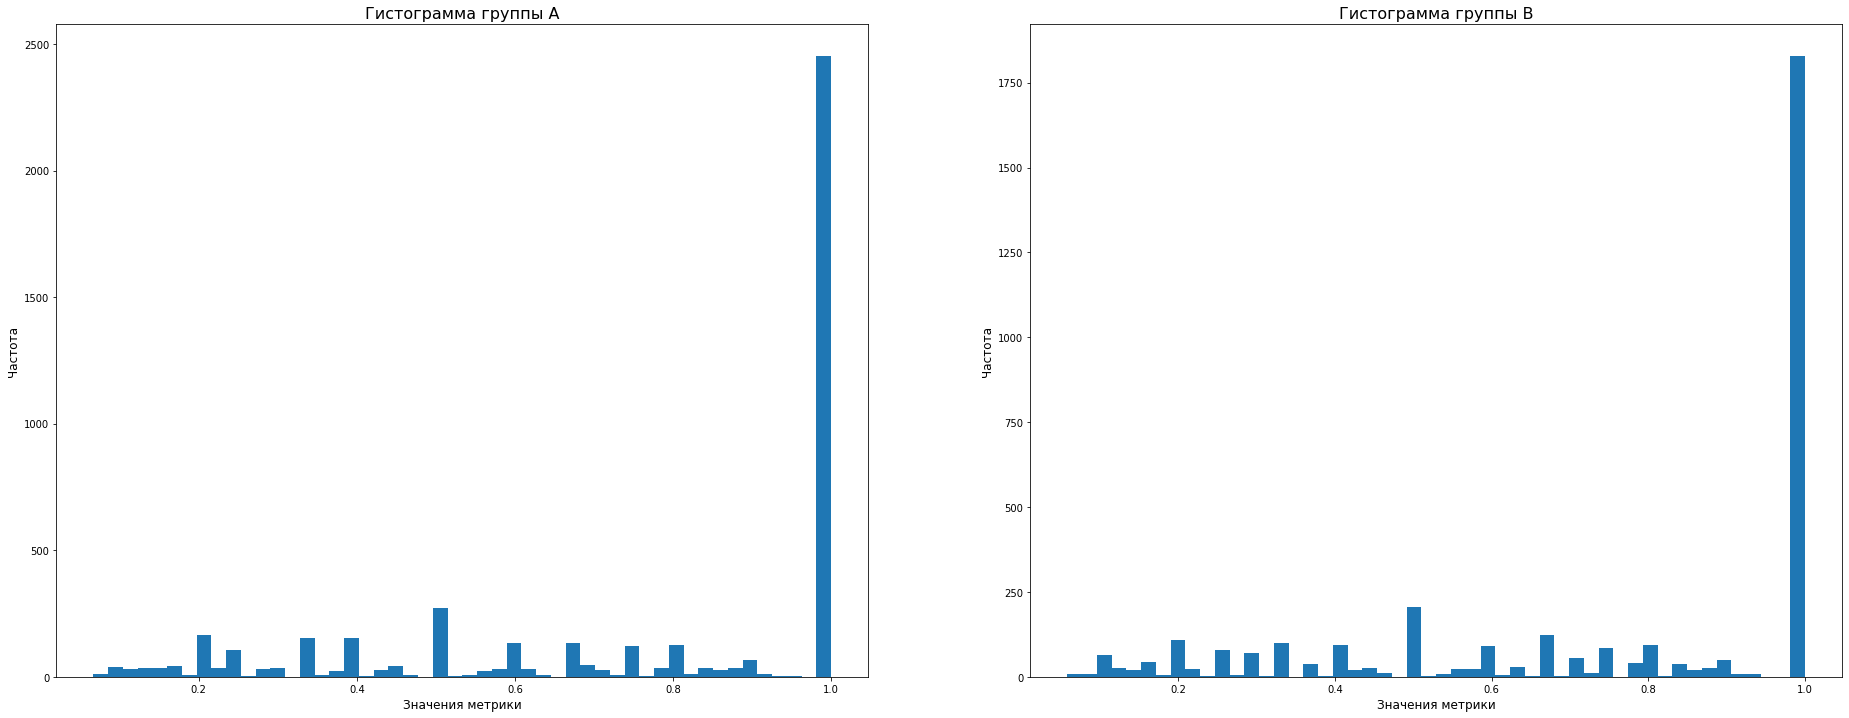

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(32,12))
ax1.hist(A_5, bins=50);
ax1.set_title("Гистограмма группы А", fontsize = 16);
ax1.set_xlabel("Значения метрики", fontsize = 12);
ax1.set_ylabel("Частота", fontsize = 12);
ax2.hist(B_5, bins=50);
ax2.set_title("Гистограмма группы B", fontsize = 16);
ax2.set_xlabel("Значения метрики", fontsize = 12);
ax2.set_ylabel("Частота", fontsize = 12);

In [80]:
print("Среднее значение метрики в группе А : %s" %A_5.mean())
print("Среднее значение метрики в группе B : %s"%B_5.mean())

Среднее значение метрики в группе А : 0.7615838991498777
Среднее значение метрики в группе B : 0.7564976441639704


In [81]:
shapiro(A_5)

(0.7713507413864136, 0.0)

In [82]:
shapiro(B_5)

(0.7792290449142456, 0.0)

Данные в обеих группах распределены не нормально

Попробуем несколько непараметрических критериев

- Двухвыборочный критерий Колмогорова-Смирнова

In [83]:
ks_2samp(A_5, B_5)

Ks_2sampResult(statistic=0.01283722534269739, pvalue=1.0)

- Манна-Уитни

In [84]:
mannwhitneyu(A_5, B_5)

MannwhitneyuResult(statistic=8144665.5, pvalue=0.17854643929605546)

- Epps-Singleton (ES) test

In [85]:
epps_singleton_2samp(A_5, B_5)

Epps_Singleton_2sampResult(statistic=3.8858430546532046, pvalue=0.4216757089333121)

По результатам трех тестов: разница между распределениями статистически не значима -> результаты A/B тестирования статистически не значимы -> эффект не значим